In [ ]:
import torch
from torchvision import transforms
from tqdm import tqdm
from torchvision.utils import make_grid
from torchvision import datasets
from torch.utils.data import DataLoader
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2e6dc7bc-ade1-3bd5-e086-f379bd858c05)


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/Shareddrives/NewAnimeGAN/female_big_faces_by_year"

# Loading and preprocessing

In [ ]:
image_size = 64
batch_size = 32
latent_dim = 100
channels = 3
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
normal_dataset = datasets.ImageFolder(data_path, transform=transforms.Compose([
  transforms.Resize(image_size),
  transforms.CenterCrop(image_size),
  transforms.ToTensor(),
  transforms.Normalize(*normalization_stats)
]))

In [ ]:
#subset = list(range(0, 5*32))
#trainset = torch.utils.data.Subset(normal_dataset, subset)
#dataloader = torch.utils.data.DataLoader(trainset, batch_size=32,
#                                            shuffle=True, num_workers=2, pin_memory=False)

In [ ]:
dataloader = DataLoader(normal_dataset,
                       batch_size,
                       shuffle=True,
                       num_workers=2,
                       pin_memory=False)

In [ ]:
def denorm(image):
  return image * normalization_stats[1][0] + normalization_stats[0][0]

In [ ]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [ ]:
def show_batch(dataloader, nmax=64):
  for images, _ in dataloader:
    show_images(images, nmax)
    break

In [ ]:
def plot_history(d_hist, g_hist, data, save_path):
  plt.plot(d_hist, label="d1_loss")
  plt.plot(g_hist, label="g_loss")
  plt.legend()
  filename = save_path + f"/plot_hist_{str(data)}.png"
  plt.savefig(filename)
  # plt.show()
  plt.close()
  print(f"Saved {filename}")

In [ ]:
#show_batch(dataloader)

In [ ]:
import os
import math
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
img_shape = (channels, image_size, image_size)

In [ ]:
results_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Results"
models_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models"
os.makedirs("/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN", exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

In [ ]:
cuda = True if torch.cuda.is_available() else False
cuda

True

#GAN

In [ ]:
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

In [ ]:
def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.init_size = image_size // 4
    self.l1 = nn.Sequential(
        nn.Linear(latent_dim, 128 * self.init_size ** 2)
    )

    self.conv_blocks = nn.Sequential(
        nn.BatchNorm2d(128),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 128, 3, stride=1, padding=1),
        nn.BatchNorm2d(128, 0.8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, 3, stride=1, padding=1),
        nn.BatchNorm2d(64, 0.8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, channels, 3, stride=1, padding=1),
        nn.Tanh(),
    )
  
  def forward(self, z):
    out = self.l1(z)
    out = out.view(out.shape[0], 128, self.init_size, self.init_size)
    img = self.conv_blocks(out)
    return img

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    def discriminator_block(in_filters, out_filters, bn=True):
      block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
               nn.LeakyReLU(0.2, inplace=True),
               nn.Dropout2d(0.25)]
      if bn:
        block.append(nn.BatchNorm2d(out_filters, 0.8))
      return block
    
    self.model = nn.Sequential(
        *discriminator_block(channels, 16, bn=False),
        *discriminator_block(16, 32),
        *discriminator_block(32, 64),
        *discriminator_block(64, 128),
    )

    ds_size = image_size // 2 ** 4
    self.adv_layer = nn.Sequential(
        nn.Linear(128 * ds_size ** 2, 1),
        nn.Sigmoid()
    )
  
  def forward(self, img):
    out = self.model(img)
    out = out.view(out.shape[0], -1)
    validity = self.adv_layer(out)

    return validity

In [ ]:
#adversarial_loss = torch.nn.BCELoss()

In [ ]:
#generator = Generator()
#discriminator = Discriminator()

In [ ]:
#if cuda:
#  generator.cuda()
#  discriminator.cuda()
#  adversarial_loss.cuda()

In [ ]:
#generator.apply(weights_init_normal)
#discriminator.apply(weights_init_normal)

In [ ]:
#optimizer_G = torch.optim.Adam(generator.parameters(),
#                               lr=lr,
#                               betas=(beta_1, beta_2))
#optimizer_D = torch.optim.Adam(discriminator.parameters(),
 #                              lr=lr,
 #                              betas=(beta_1, beta_2))

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
len(dataloader)

1115

In [ ]:
def train_GAN(n_epochs = 200, index = 0):
  d_hist, g_hist = list(), list()

  for epoch in range(n_epochs):

    i = 0
    for imgs, _ in tqdm(dataloader):
      
      valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
      fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

      real_imgs = Variable(imgs.type(Tensor))

      optimizer_G.zero_grad()

      z = Variable(Tensor(np.random.normal(0,1,(imgs.shape[0], latent_dim))))

      gen_imgs = generator(z)

      g_loss = adversarial_loss(discriminator(gen_imgs), valid)

      g_loss.backward()
      optimizer_G.step()

      optimizer_D.zero_grad()

      real_loss = adversarial_loss(discriminator(real_imgs), valid)
      fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
      d_loss = (real_loss + fake_loss) / 2

      d_loss.backward()
      optimizer_D.step()

      d_hist.append(d_loss.item())
      g_hist.append(g_loss.item())

      i += 1

      batches_done = epoch * len(dataloader) + i
      if batches_done % (len(dataloader)*1) == 0:
        save_image(gen_imgs.data[:16], f"{results_path}/{index}_{batches_done}.png", nrow=4, normalize=True)
        print(
          "[Epoch %d %d] [Batch %d %d] [D loss: %f] [G loss: %f]"
          %(epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )
        plot_history(d_hist, g_hist, index, models_path)
        # show_images(gen_imgs.data[:16].to('cpu'), nmax=16)

In [ ]:
#torch.save(generator.state_dict(), models_path)

In [ ]:
#generator = Generator()
#generator.load_state_dict(torch.load(models_path))

In [ ]:
#generator.eval()

#GIF MAKER

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
  # interpolate ratios between the points
  ratios = linspace(0, 1, num=n_steps)
  # linear interpolate vectors
  vectors = list()
  #vectors = torch.Tensor()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  
  return asarray(vectors)

In [ ]:
import cv2

from numpy import linspace
from numpy import asarray
from numpy.random import randn
import PIL
from PIL import Image

gif_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/GIF_Images"
os.makedirs(gif_path, exist_ok=True)

In [ ]:
def create_gif(gifname, n_images = 1, n_frame=10):

  z = Variable(Tensor(np.random.normal(0,1,(2, latent_dim))))

  for i in range(n_images):
    latent_points = interpolate_points(z[0], z[1])

    #interpolated = torch.stack([interpolated[0], interpolated[1], interpolated[2], interpolated[3], interpolated[4], interpolated[5], interpolated[6], 
    #                        interpolated[7], interpolated[8], interpolated[9]])
    interpolated = torch.stack([latent_points[j] for j in range(n_frame)])
    gen_imgs = generator(interpolated)
    
    #print(gen_imgs.size())
    new_imgs = denorm(gen_imgs.to('cpu').detach().permute(0,2,3,1)).numpy()
    img0 = new_imgs[0]
    img1 = new_imgs[1]
    img2 = new_imgs[2]
    img3 = new_imgs[3]
    img4 = new_imgs[4]
    img5 = new_imgs[5]
    img6 = new_imgs[6]
    img7 = new_imgs[7]
    img8 = new_imgs[8]
    img9 = new_imgs[9]
    #print(new_img.shape)
    
    img0 = img0 * 255.; img0 = img0.astype(np.uint8); img0 = Image.fromarray(img0)
    img1 = img1 * 255; img1 = img1.astype(np.uint8); img1 = Image.fromarray(img1)
    img2 = img2 * 255; img2 = img2.astype(np.uint8); img2 = Image.fromarray(img2)
    img3 = img3 * 255; img3 = img3.astype(np.uint8); img3 = Image.fromarray(img3)
    img4 = img4 * 255; img4 = img4.astype(np.uint8); img4 = Image.fromarray(img4)
    img5 = img5 * 255; img5 = img5.astype(np.uint8); img5 = Image.fromarray(img5)
    img6 = img6 * 255; img6 = img6.astype(np.uint8); img6 = Image.fromarray(img6)
    img7 = img7 * 255; img7 = img7.astype(np.uint8); img7 = Image.fromarray(img7)
    img8 = img8 * 255; img8 = img8.astype(np.uint8); img8 = Image.fromarray(img8)
    img9 = img9 * 255; img9 = img9.astype(np.uint8); img9 = Image.fromarray(img9)
    img0.save(gif_path + gifname, save_all=True, append_images=[img1, img2, img3, img4, img5, img6, img7, img8, img9])
    print("GIF correctly generated")
  #plt.plot(new_img)
  #plt.savefig(gif_path + "/1.gif")
  #plt.show()

    #for img in gen_imgs.data:
    #  new_img = img.to('cpu').detach().permute(1,2,0).numpy()
    #  # new_img = cv2.resize(new_img, (32,32))
    #  plt.imshow(new_img)
   #   plt.show()

#plot_generated(gen_imgs, len(interpolated))

#saving and restoring

In [ ]:
def save_GAN():
  torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict()
            }, models_path + "/DCGAN_model800.tar")

In [ ]:
save = True

adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()

if cuda:
  generator.cuda()
  discriminator.cuda()
  adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), 
                               lr=lr, betas=(beta_1, beta_2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), 
                               lr=lr, betas=(beta_1, beta_2))

if (not (os.path.exists(models_path + "/DCGAN_model775.tar"))):
  print("training of a new model")
  generator.apply(weights_init_normal)
  discriminator.apply(weights_init_normal)

  train_GAN(n_epochs=50, index=0)
  generator.eval()

else:
  print("resuming training from a loaded model")
  checkpoint = torch.load(models_path + "/DCGAN_model775.tar")
  generator.load_state_dict(checkpoint['generator_state_dict'])
  discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
  optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
  optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

  #generator.eval()
  #discriminator.eval()

  train_GAN(n_epochs=25, index=30) #change index everytime

if(save):
   save_GAN()

resuming training from a loaded model


100%|██████████| 1115/1115 [01:16<00:00, 11.64it/s]

[Epoch 0 25] [Batch 1115 1115] [D loss: 0.623708] [G loss: 0.808707]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|██████████| 1115/1115 [01:18<00:00, 11.22it/s]

[Epoch 1 25] [Batch 1115 1115] [D loss: 0.671815] [G loss: 0.592444]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 15.28it/s]

[Epoch 2 25] [Batch 1115 1115] [D loss: 0.742925] [G loss: 0.749261]


100%|██████████| 1115/1115 [01:17<00:00, 14.44it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|██████████| 1115/1115 [01:16<00:00, 10.64it/s]

[Epoch 3 25] [Batch 1115 1115] [D loss: 0.625066] [G loss: 0.906097]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 15.22it/s]

[Epoch 4 25] [Batch 1115 1115] [D loss: 0.569416] [G loss: 0.972992]


100%|██████████| 1115/1115 [01:17<00:00, 14.42it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.45it/s]

[Epoch 5 25] [Batch 1115 1115] [D loss: 0.734831] [G loss: 0.649366]


100%|██████████| 1115/1115 [01:17<00:00, 14.48it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.49it/s]

[Epoch 6 25] [Batch 1115 1115] [D loss: 0.659159] [G loss: 0.575312]


100%|██████████| 1115/1115 [01:16<00:00, 14.50it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.71it/s]

[Epoch 7 25] [Batch 1115 1115] [D loss: 0.850710] [G loss: 0.888886]


100%|██████████| 1115/1115 [01:17<00:00, 14.46it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.45it/s]

[Epoch 8 25] [Batch 1115 1115] [D loss: 0.497256] [G loss: 1.272339]


100%|██████████| 1115/1115 [01:16<00:00, 14.50it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|██████████| 1115/1115 [01:16<00:00, 10.96it/s]

[Epoch 9 25] [Batch 1115 1115] [D loss: 0.627162] [G loss: 0.740639]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|██████████| 1115/1115 [01:16<00:00, 10.70it/s]

[Epoch 10 25] [Batch 1115 1115] [D loss: 0.697579] [G loss: 1.197196]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|██████████| 1115/1115 [01:16<00:00, 10.99it/s]

[Epoch 11 25] [Batch 1115 1115] [D loss: 0.683449] [G loss: 1.067517]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|██████████| 1115/1115 [01:16<00:00, 11.08it/s]

[Epoch 12 25] [Batch 1115 1115] [D loss: 0.852445] [G loss: 0.694602]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|██████████| 1115/1115 [01:16<00:00, 10.92it/s]

[Epoch 13 25] [Batch 1115 1115] [D loss: 0.608000] [G loss: 0.956670]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 15.23it/s]

[Epoch 14 25] [Batch 1115 1115] [D loss: 0.783934] [G loss: 0.691518]


100%|██████████| 1115/1115 [01:16<00:00, 14.53it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.36it/s]

[Epoch 15 25] [Batch 1115 1115] [D loss: 0.880842] [G loss: 0.699598]


100%|██████████| 1115/1115 [01:17<00:00, 14.45it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.96it/s]

[Epoch 16 25] [Batch 1115 1115] [D loss: 0.996099] [G loss: 0.521915]


100%|██████████| 1115/1115 [01:16<00:00, 14.55it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.37it/s]

[Epoch 17 25] [Batch 1115 1115] [D loss: 0.661628] [G loss: 0.812329]


100%|██████████| 1115/1115 [01:16<00:00, 14.54it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.82it/s]

[Epoch 18 25] [Batch 1115 1115] [D loss: 0.708237] [G loss: 0.678149]


100%|██████████| 1115/1115 [01:17<00:00, 14.47it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 15.14it/s]

[Epoch 19 25] [Batch 1115 1115] [D loss: 0.694490] [G loss: 0.828914]


100%|██████████| 1115/1115 [01:16<00:00, 14.50it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.28it/s]

[Epoch 20 25] [Batch 1115 1115] [D loss: 0.763921] [G loss: 0.945643]


100%|██████████| 1115/1115 [01:16<00:00, 14.57it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:15<00:00, 15.14it/s]

[Epoch 21 25] [Batch 1115 1115] [D loss: 0.656318] [G loss: 0.874988]


100%|██████████| 1115/1115 [01:16<00:00, 14.60it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.79it/s]

[Epoch 22 25] [Batch 1115 1115] [D loss: 0.530937] [G loss: 0.886805]


100%|██████████| 1115/1115 [01:16<00:00, 14.49it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 15.33it/s]

[Epoch 23 25] [Batch 1115 1115] [D loss: 0.675094] [G loss: 1.182264]


100%|██████████| 1115/1115 [01:16<00:00, 14.58it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


100%|█████████▉| 1113/1115 [01:16<00:00, 14.82it/s]

[Epoch 24 25] [Batch 1115 1115] [D loss: 0.845646] [G loss: 1.387945]


100%|██████████| 1115/1115 [01:16<00:00, 14.59it/s]

Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/DCGAN/Models/plot_hist_30.png


In [ ]:
create_gif("/DCGAN_GIF750.gif")

GIF correctly generated


In [ ]:
generator.eval()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=32768, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

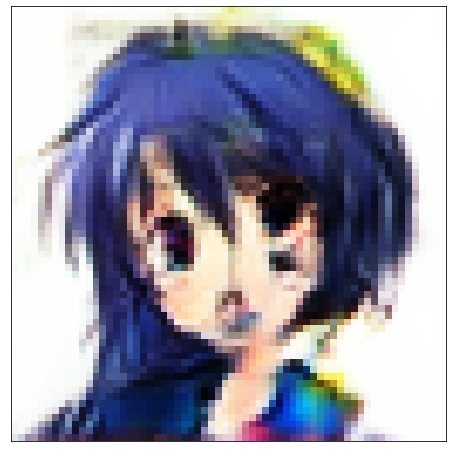

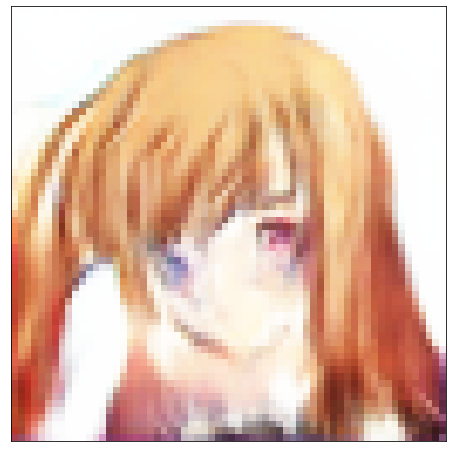

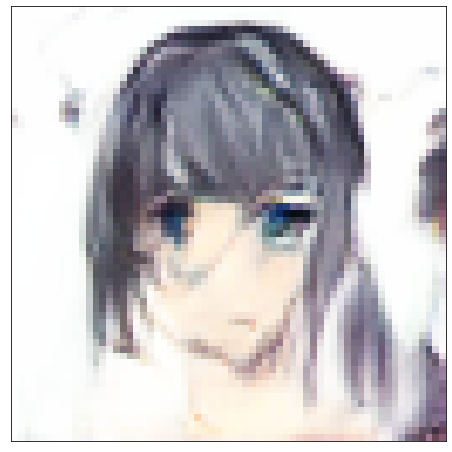

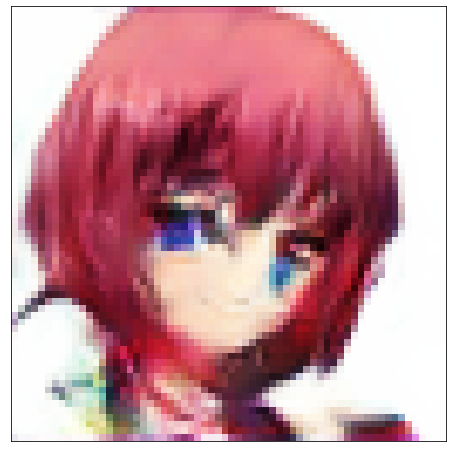

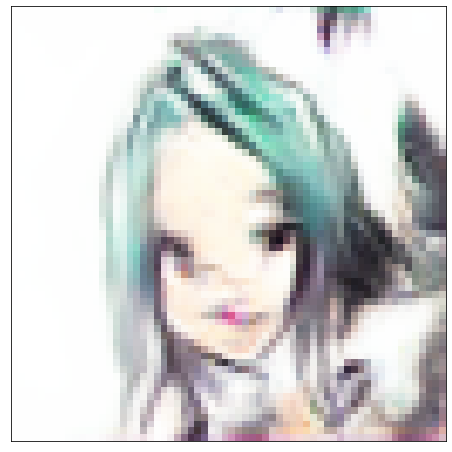

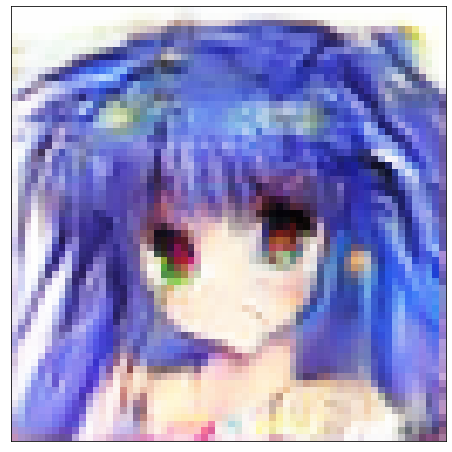

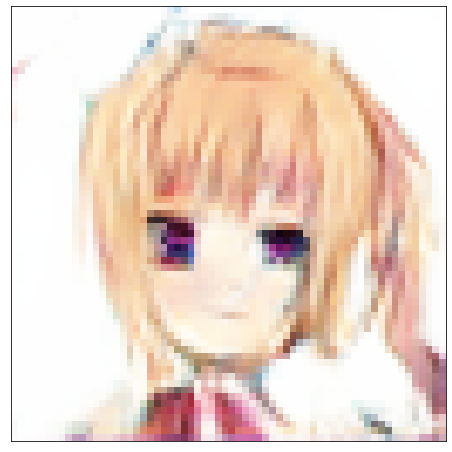

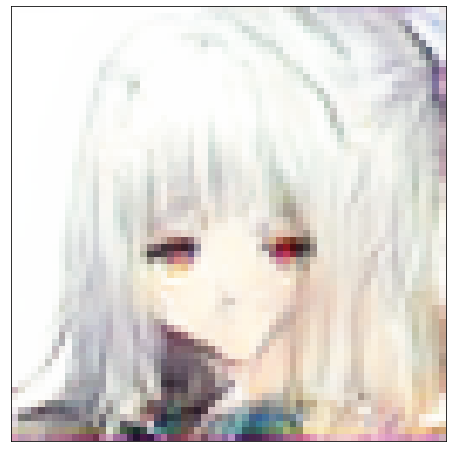

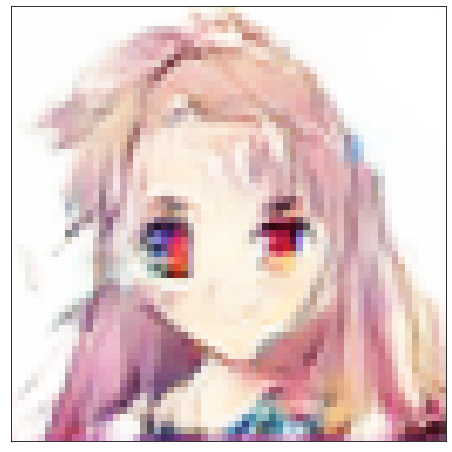

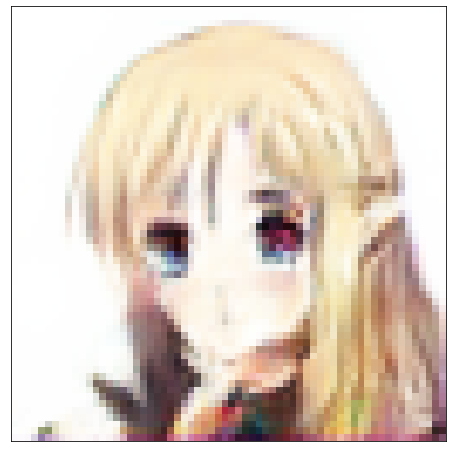

In [ ]:
from google.colab.patches import cv2_imshow

z = Variable(Tensor(np.random.normal(0,1,(10, latent_dim))))

gen_imgs = generator(z)

for gen_img in gen_imgs:
  # print(gen_img.shape)
  show_images(gen_img.cpu(), 3)

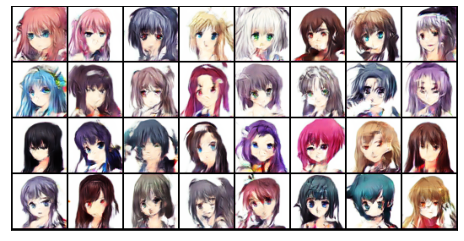

In [ ]:
z = Variable(Tensor(np.random.normal(0,1,(32, latent_dim))))

gen_imgs = generator(z)
show_images(gen_imgs.cpu())

# wrong code


In [ ]:
#save_image(gen_imgs.data[:16], f"{results_path}/20000000.png", nrow=4, normalize=True)

In [ ]:
#import cv2
#from numpy import linspace
#from numpy import asarray
#from numpy.random import randn

#z = Variable(Tensor(np.random.normal(0,1,(imgs.shape[0], latent_dim))))
#for i in range(imgs.shape[0]-1):
#  interpolated = interpolate_points(z[i], z[i+1])

#  interpolated = torch.stack([interpolated[0], interpolated[1], interpolated[2], interpolated[3], interpolated[4], interpolated[5], interpolated[6], 
#                          interpolated[7], interpolated[8], interpolated[9]])

#  gen_imgs = generator(interpolated)
#  for img in gen_imgs.data:
#    new_img = img.to('cpu').detach().permute(1,2,0).numpy()
    # new_img = cv2.resize(new_img, (32,32))
#    plt.imshow(new_img)
#    plt.axis("off")
#    plt.show()

#plot_generated(gen_imgs, len(interpolated))


In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
  # interpolate ratios between the points
  ratios = linspace(0, 1, num=n_steps)
  # linear interpolate vectors
  vectors = list()
  #vectors = torch.Tensor()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  
  return asarray(vectors)

In [ ]:
def plot_generated(examples, n):
# plot images
  for i in range(n):
    # define subplot
    plt.subplot(1, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :])
  plt.show()